# Environment

In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

# Globals

In [2]:
ORGANIZATION = ''
PROJECT_ID = ''
REGION = ""

BUCKET = ''

In [3]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'teste'
BQ_TABLE = 'diabetes_with_split'

In [4]:
EXPERIMENT = 'logistic-regression'
SERIES = 'bqml'

In [5]:
# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

In [6]:
# Model Training
VAR_TARGET = 'Diabetes'
VAR_OMIT = 'ML_SPLIT'

# Vertex AI - BigQuery ML Modelling

In [7]:
# Bigquery Client and Vertex AI Inti
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project = PROJECT_ID, location = REGION)

In [8]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

## Data analysis

In [9]:
query = f"""
    SELECT ML_SPLIT, {VAR_TARGET}, count(*) as n
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    GROUP BY ML_SPLIT, {VAR_TARGET}
    ORDER BY ML_SPLIT, {VAR_TARGET}
"""
print(query)


    SELECT ML_SPLIT, Diabetes, count(*) as n
    FROM `84023181660.teste.diabetes_with_split`
    GROUP BY ML_SPLIT, Diabetes
    ORDER BY ML_SPLIT, Diabetes



In [10]:
# Data analysis
bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ML_SPLIT,Diabetes,n
0,TEST,0,4385
1,TEST,1,793
2,TRAIN,0,170752
3,TRAIN,1,32079
4,VALIDATE,0,38566
5,VALIDATE,1,7105


In [11]:
query = f"""
    WITH
        COUNTS as (SELECT ML_SPLIT, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY ML_SPLIT, {VAR_TARGET})

    SELECT *,
        SUM(n) OVER() as total,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY ML_SPLIT)) as n_pct_split,
        SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
    FROM COUNTS
"""
print(query)


    WITH
        COUNTS as (SELECT ML_SPLIT, Diabetes, count(*) as n FROM `84023181660.teste.diabetes_with_split` GROUP BY ML_SPLIT, Diabetes)

    SELECT *,
        SUM(n) OVER() as total,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY Diabetes)) as n_pct_class,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY ML_SPLIT)) as n_pct_split,
        SAFE_DIVIDE(SUM(n) OVER(PARTITION BY Diabetes), SUM(n) OVER()) as class_pct_total
    FROM COUNTS



In [12]:
review = bq.query(query = query).to_dataframe()
review

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ML_SPLIT,Diabetes,n,total,n_pct_class,n_pct_split,class_pct_total
0,TEST,0,4385,253680,0.020519,0.846852,0.842412
1,TEST,1,793,253680,0.019836,0.153148,0.157588
2,TRAIN,0,170752,253680,0.799015,0.841844,0.842412
3,TRAIN,1,32079,253680,0.802436,0.158156,0.157588
4,VALIDATE,0,38566,253680,0.180465,0.844431,0.842412
5,VALIDATE,1,7105,253680,0.177727,0.155569,0.157588


In [13]:
print(f'This run will create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'This run will create Vertex AI model: {BQ_PROJECT}.{BQ_DATASET}.bqml_{SERIES}_{EXPERIMENT}')
print(f'The runs timestamp Is: {TIMESTAMP}')

This run will create BQML model: 84023181660.teste.bqml_logistic-regression_20251213144617
This run will create Vertex AI model: 84023181660.teste.bqml_bqml_logistic-regression
The runs timestamp Is: 20251213144617


In [14]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        calculate_p_values = FALSE,
        CATEGORY_ENCODING_METHOD = 'DUMMY_ENCODING',
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}),
    CASE
        WHEN ML_SPLIT = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE ML_SPLIT != 'TEST'
"""
print(query)


CREATE OR REPLACE MODEL `84023181660.teste.bqml_logistic-regression_20251213144617`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        calculate_p_values = FALSE,
        CATEGORY_ENCODING_METHOD = 'DUMMY_ENCODING',
        input_label_cols = ['Diabetes'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_bqml_logistic-regression',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20251213144617']
    ) AS
SELECT * EXCEPT(ML_SPLIT),
    CASE
        WHEN ML_SPLIT = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `84023181660.teste.diabetes_with_split`
WHERE ML_SPLIT != 'TEST'



In [15]:
job = bq.query(query = query)
job.result()

In [16]:
(job.ended-job.started).total_seconds()

77.385

In [17]:
job.total_bytes_processed

46555275

In [18]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

# View model:
* BigQuery
* Model Garden


In [19]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Age,1.0,13.0,8.037731,8.0,3.051330,<NA>,0,<NA>
1,AnyHealthcare,0.0,1.0,0.950910,1.0,0.216057,<NA>,0,<NA>
2,BMI,12.0,98.0,28.390049,27.0,6.624816,<NA>,0,<NA>
3,CholCheck,0.0,1.0,0.962668,1.0,0.189573,<NA>,0,<NA>
4,DiffWalk,0.0,1.0,0.168909,0.0,0.374673,<NA>,0,<NA>
5,Education,1.0,6.0,5.051595,5.0,0.985361,<NA>,0,<NA>
6,Fruits,0.0,1.0,0.634494,1.0,0.481573,<NA>,0,<NA>
7,GenHlth,1.0,5.0,2.511041,2.0,1.069214,<NA>,0,<NA>
8,HeartDiseaseorAttack,0.0,1.0,0.094359,0.0,0.292329,<NA>,0,<NA>
9,HighBP,0.0,1.0,0.429565,0.0,0.495015,<NA>,0,<NA>


In [20]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.671840,0.671757,0.2,5225
1,0,1,0.650734,0.650400,0.4,6138
2,0,2,0.638227,0.637511,0.8,4448
3,0,3,0.621793,0.620928,1.6,5934
4,0,4,0.580226,0.579643,3.2,5987
5,0,5,0.548311,0.547563,6.4,4937
6,0,6,0.508128,0.508140,12.8,6795


In [21]:
weights = bq.query(
    query = f"""
        SELECT *
        FROM ML.WEIGHTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
    """
).to_dataframe()
weights

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,processed_input,weight,category_weights
0,Age,0.144270,[]
1,AnyHealthcare,0.205919,[]
2,BMI,0.068741,[]
3,CholCheck,1.162271,[]
4,DiffWalk,-0.179968,[]
5,Education,0.016571,[]
6,Fruits,0.007287,[]
7,GenHlth,0.454703,[]
8,HeartDiseaseorAttack,0.096347,[]
9,HighBP,0.643115,[]


In [22]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE ML_SPLIT='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE ML_SPLIT='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE ML_SPLIT='TRAIN'))
"""
bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,VALIDATE,0.340724,0.707248,0.741565,0.459891,0.508140,0.802803
1,TEST,0.326531,0.686003,0.735226,0.442456,0.512630,0.792622
2,TRAIN,0.345414,0.707379,0.741706,0.464172,0.508128,0.804894


In [23]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE ML_SPLIT = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,expected_label,_0,_1
0,0,127749,43003
1,1,9387,22692


In [24]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE ML_SPLIT = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,expected_label,_0,_1
0,0,28843,9723
1,1,2080,5025


In [25]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE ML_SPLIT = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,expected_label,_0,_1
0,0,3263,1122
1,1,249,544


# Predictions

In [26]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE ML_SPLIT = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [27]:
pred.columns

Index(['predicted_Diabetes', 'predicted_Diabetes_probs', 'ML_SPLIT',
       'Diabetes', 'Age', 'AnyHealthcare', 'BMI', 'CholCheck', 'DiffWalk',
       'Education', 'Fruits', 'GenHlth', 'HeartDiseaseorAttack', 'HighBP',
       'HighChol', 'HvyAlcoholConsump', 'Income', 'MentHlth', 'NoDocbcCost',
       'PhysActivity', 'PhysHlth', 'Sex', 'Smoker', 'Stroke', 'Veggies'],
      dtype='object')

In [27]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'ML_SPLIT']]

,Diabetes,predicted_Diabetes,predicted_Diabetes_probs,ML_SPLIT
0,1,1,"[{'label': 1, 'prob': 0.7447458657293569}, {'l...",TEST
1,0,1,"[{'label': 1, 'prob': 0.7271845853302593}, {'l...",TEST
2,0,0,"[{'label': 1, 'prob': 0.22471921600557626}, {'...",TEST
3,0,0,"[{'label': 1, 'prob': 0.4112645792287173}, {'l...",TEST
4,0,0,"[{'label': 1, 'prob': 0.10512437717632106}, {'...",TEST
...,...,...,...,...
5173,0,0,"[{'label': 1, 'prob': 0.15284052680138482}, {'...",TEST
5174,0,1,"[{'label': 1, 'prob': 0.7888184041489615}, {'l...",TEST
5175,0,0,"[{'label': 1, 'prob': 0.08850139020117259}, {'...",TEST
5176,0,1,"[{'label': 1, 'prob': 0.6443668842070687}, {'l...",TEST


In [28]:
# Primeiro registro
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.25525413427064314},
  {'label': 1, 'prob': 0.7447458657293569}]]

In [29]:
metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

array([[3263, 1122],
       [ 249,  544]])

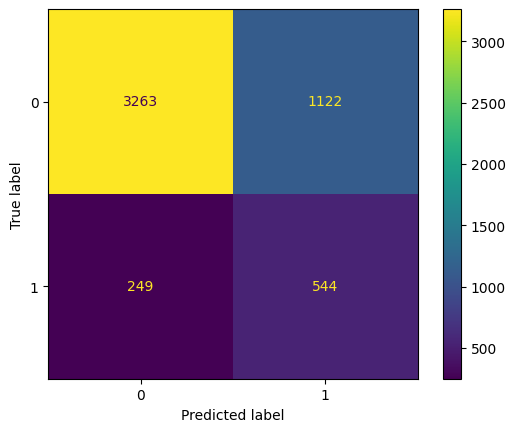

In [30]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))
)
disp.plot()

In [32]:
metrics.accuracy_score(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

0.735225955967555

In [33]:
print(metrics.classification_report(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}'])))

              precision    recall  f1-score   support

           0       0.93      0.74      0.83      4385
           1       0.33      0.69      0.44       793

    accuracy                           0.74      5178
   macro avg       0.63      0.72      0.63      5178
weighted avg       0.84      0.74      0.77      5178



# Explanaitions

## Point Explanations

In [34]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE ML_SPLIT = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [35]:
explain.head()

,predicted_Diabetes,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,ML_SPLIT,Diabetes,Age,AnyHealthcare,...,HvyAlcoholConsump,Income,MentHlth,NoDocbcCost,PhysActivity,PhysHlth,Sex,Smoker,Stroke,Veggies
0,1,0.744746,"[{'feature': 'GenHlth', 'attribution': 0.67703...",-0.626901,1.070783,0.0,TEST,1,9,1,...,0,4,0,0,1,7,0,1,1,0
1,1,0.727185,"[{'feature': 'GenHlth', 'attribution': 1.13173...",-0.626901,0.980385,0.0,TEST,0,11,1,...,0,6,0,0,0,0,0,1,0,1
2,0,0.775281,"[{'feature': 'BMI', 'attribution': -0.43925724...",-0.626901,-1.238374,0.0,TEST,0,10,1,...,0,4,0,0,0,0,1,1,0,0
3,0,0.588735,"[{'feature': 'BMI', 'attribution': 0.523114340...",-0.626901,-0.358740,0.0,TEST,0,7,1,...,0,8,1,0,1,0,0,0,0,1
4,0,0.894876,"[{'feature': 'Age', 'attribution': -0.72679511...",-0.626901,-2.141541,0.0,TEST,0,3,1,...,1,8,10,0,1,2,0,0,0,1


In [36]:
explanation = explain.iloc[0]['top_feature_attributions']

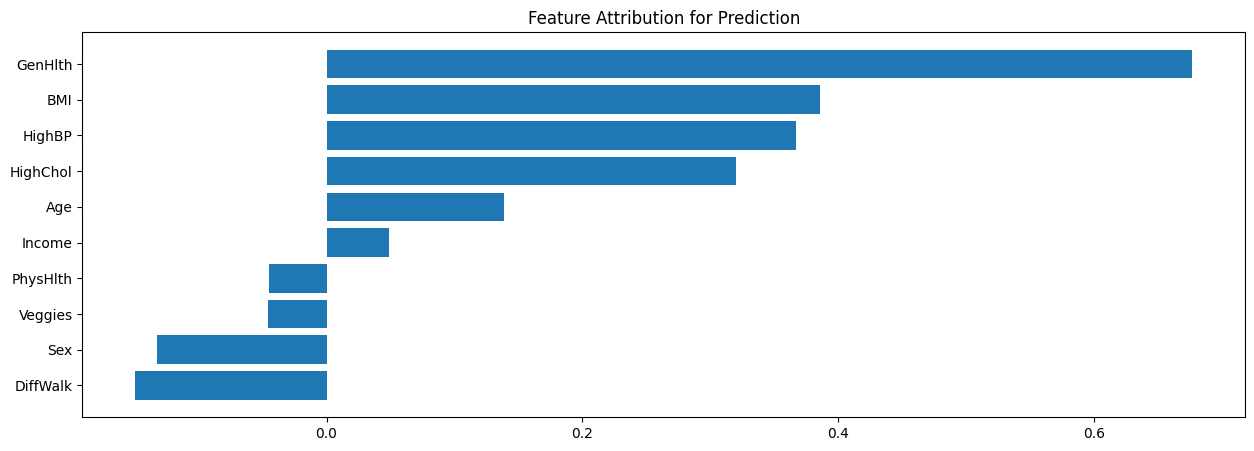

In [37]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

## Global Explainability

In [38]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [39]:
gexplain.head()

,feature,attribution
0,GenHlth,0.407694
1,Age,0.360719
2,BMI,0.323925
3,HighBP,0.314973
4,HighChol,0.271521


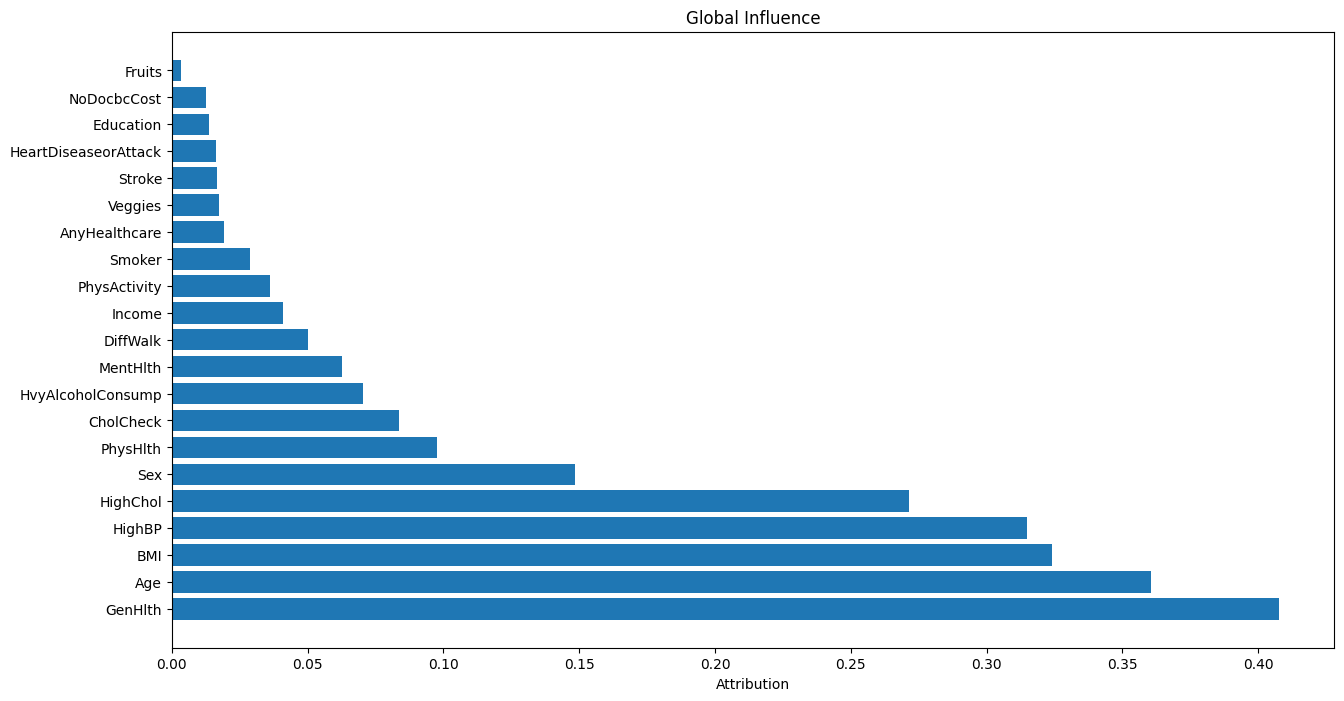

In [40]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

# Seving with Vertex AI

* [ ] Deploy via UI: Model Registry -> Model -> Version -> Tab deploy and test -> Deploy to endpoint (or via endpoint, create)
      

# Predictions

In [60]:
n = 10

In [61]:
query = f"""
        SELECT * EXCEPT({VAR_TARGET}, ML_SPLIT)
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE ML_SPLIT='TEST'
        LIMIT {n}
        """
print(query)


        SELECT * EXCEPT(Diabetes, ML_SPLIT)
        FROM `84023181660.teste.diabetes_with_split`
        WHERE ML_SPLIT='TEST'
        LIMIT 10
        


In [62]:
n = 10
pred = bq.query(query).to_dataframe()

/datascience/miniconda/envs/datascience/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [63]:
newobs = pred.to_dict(orient = 'records')

In [72]:
# TODO: ensure the name of the model is correct
endpoint = aiplatform.Endpoint.list(filter = f"display_name=bqml_logistic_regression_dec")[0]
endpoint

resource name: projects/84023181660/locations/us-central1/endpoints/920624384471728128

In [73]:
print(f"Endpoint Found: {endpoint.display_name}")

Endpoint Found: bqml_logistic_regression_dec


In [74]:
prediction = endpoint.predict(instances = newobs)
prediction

Prediction(predictions=[{'Diabetes_probs': [0.7447458657292959, 0.2552541342707041], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['1']}, {'Diabetes_probs': [0.7271845853302151, 0.2728154146697849], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['1']}, {'Diabetes_probs': [0.224719216005571, 0.775280783994429], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['0']}, {'Diabetes_probs': [0.4112645792287313, 0.5887354207712687], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['0']}, {'Diabetes_probs': [0.1051243771763286, 0.8948756228236714], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['0']}, {'Diabetes_probs': [0.6484586552596804, 0.3515413447403196], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['1']}, {'Diabetes_probs': [0.4177700481145671, 0.5822299518854328], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['0']}, {'Diabetes_probs': [0.63482301668872, 0.36517698331128], 'Diabetes_values': ['1', '0'], 'predicted_Diabetes': ['1']}, {'Diab

In [75]:
prediction.predictions[0]

{'Diabetes_probs': [0.7447458657292959, 0.2552541342707041],
 'Diabetes_values': ['1', '0'],
 'predicted_Diabetes': ['1']}

# Clean Up
* Endpoint
* Models